<h1 align="center">Volume 4: Spectral 1.</h1>

    NAME: Daniel Smith 
    Section 2
    DATE: 13 January 2022

In [139]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import barycentric_interpolate
from numpy import linalg as la
from scipy.optimize import root
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate

%matplotlib inline

# Setup

In [130]:
def cheb(N):
    x = np.cos((np.pi/N)*np.linspace(0,N,N+1))
    x.shape = (N+1,1)
    lin = np.linspace(0,N,N+1)
    lin.shape = (N+1,1)
    
    c = np.ones((N+1,1))
    c[0], c[-1] = 2., 2.
    c = c*(-1.)**lin
    X = x*np.ones(N+1) # broadcast along 2nd dimension (columns)
    
    dX = X - X.T
    
    D = (c*(1./c).T)/(dX + np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    x.shape = (N+1,)
    # Here we return the differentiation matrix and the Chebyshev points,
    # numbered from x_0 = 1 to x_N = -1
    return D, x

# Problem 1

Use the differentiation matrix to numerically approximate the derivative of u(x)) on a grid of N Chebychev points where N = 6, 8, and 10.
Then use barycentric interpolation (scipy.interpolate.barycentric_interpolate) to
approximate u0 on a grid of 100 evenly spaced points.
Graphically compare your approximation to the exact derivative

In [131]:
# Initialize N values, colors, and labels 
N, colors, labels = [6, 8, 10], ["orange", "green", "blue"], ["N=6", "N=8", "N=10"]
# Initialize u and u'
u, u_prime = lambda x: np.exp(x)*np.cos(6*x), lambda x: -np.exp(x)*6*np.sin(6*x) + np.cos(6*x)*np.exp(x)
u, u_prime = np.vectorize(u), np.vectorize(u_prime)

for n, col, lab in zip(N, colors, labels):
    D, x = cheb(n) # Get D and x 
    U_prime = D@u(x) # Approximate U'
    bary = barycentric_interpolate(x, U_prime, np.linspace(min(x), max(x), 100)) # Interpolate 
    plt.plot(dom, bary, color = col, label = lab)

# Generate plots 
plt.plot(dom, u_prime(dom), color = "red", label = "True Derivative")
plt.legend()
plt.xlabel("x")
plt.ylabel("u'(x)")
plt.title(r"$u'(x)=-6e^xsin(6x)+cos(6x)e^x$")
plt.show() 

# Problem 2

Use the pseudospectral method to solve the boundary value problem.
Use N = 8 in the cheb(N) method and use barycentric interpolation to approximate u on
100 evenly spaced points. Compare your numerical solution with the exact solution.

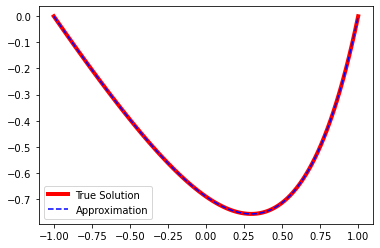

In [132]:
D, x = cheb(8) # Get D, x, and D2
D2 = np.dot(D, D)
D2[0,:], D2[-1,:] = 0, 0
D2[0,0], D2[-1,-1] = 1, 1

# Initialize u and f 
u, f = lambda x: (-np.cosh(2) - np.sinh(2)*x + np.exp(2*x))/4, lambda x: np.exp(2*x)
u, f = np.vectorize(u), np.vectorize(f)

# Update the F vector 
F = f(x)
F[0], F[-1] = 0, 0

U = np.linalg.solve(D2, F) # Solve for U
dom = np.linspace(-1, 1, 100)

bary = barycentric_interpolate(x, U, dom) # Interpolate 

# Generate plots 
plt.plot(dom, u(dom), color = "red", label = "True Solution", linewidth = 4)
plt.plot(dom, bary, "--", color = "blue", label = "Approximation")
plt.legend()
plt.show()

# Problem 3

Use the pseudospectral method to solve the boundary value problem.
Use N = 8 in the cheb(N) method and use barycentric interpolation to approximate u on
100 evenly spaced points.

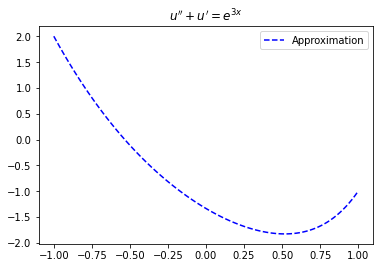

In [134]:
D, x = cheb(8) # Get D, x, and D2
D2 = np.dot(D, D)
oper = D2 + D
oper[0,:], oper[-1,:] = 0, 0
oper[0,0], oper[-1,-1] = 1, 1

# Initialize f 
f = lambda x: np.exp(3*x)
f = np.vectorize(f)

# Build F vector 
F = f(x)
F[0], F[-1] = -1, 2

U = np.linalg.solve(oper, F) # Solve for U
dom = np.linspace(-1, 1, 100)

bary = barycentric_interpolate(x, U, dom) # Interpolate 

# Generate plot 
plt.plot(dom, bary, "--", color = "blue", label = "Approximation")
plt.legend()
plt.title(r"$u''+u'=e^{3x}$")
plt.show()

# Problem 4

Use the pseudospectral method to solve the boundary value problem
for several values of λ: λ = 4, 8, 12. Begin by transforming this BVP onto the domain −1 <
x < 1. Use N = 20 in the cheb(N) method and use barycentric interpolation to approximate
u on 100 evenly spaced points

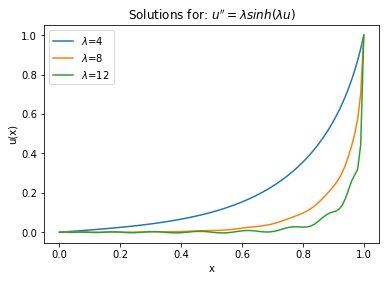

In [135]:
dom = np.linspace(-1, 1, 100) # Initialize domain for interpolating 
lam = [4, 8, 12] # Lambda values 
D, x = cheb(20) # Get D, x, and D2
D2 = np.dot(D, D)

for l in lam:
    def F(U):
        # Find the root of the function 
        out = -4*D2@U + l*np.sinh(l*U)
        out[0] = U[0] - 1
        out[-1] = U[-1]
        return out
    
    guess = np.ones_like(x) # Initial guess 
    sol = root(F, guess).x # Solve
    bary = barycentric_interpolate(x, sol, dom) # Interpolate 
    plt.plot((dom + 1)*0.5, bary, label = r"$\lambda$=" + str(l))
  
# Generate plots 
plt.title(r"Solutions for: $u''=\lambda sinh(\lambda u)$")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.show()

# Problem 5

Find the function y(x) that satisies y(−1) = 1, y(1) = 7, and whose surface of
revolution (about the x-axis) minimizes surface area. Compute the surface area, and plot the
surface. Use N = 50 in the cheb(N) method and use barycentric interpolation to approximate
u on 100 evenly spaced points.
Below is sample code for creating the 3D wireframe figure.

In [146]:
dom = np.linspace(-1, 1, 100) # Initialize domain for interpolating 
D, x = cheb(50) # Get D, x, and D2
D2 = np.dot(D, D)

def F_(U):
    # Find the root of the function 
    out = np.multiply(U, D2@U) - np.multiply(D@U, D@U) - np.ones_like(x)
    out[0] = U[0] - 7
    out[-1] = U[-1] - 1
    return out

guess = np.ones_like(x)*2 # Set initial guess 
sol = root(F_, guess).x # Solve 
bary = barycentric_interpolate(x, sol, dom) # Interpolate 

# This code was given to us in the lab manual 
lin = np.linspace(-1, 1, 100)
theta = np.linspace(0, 2*np.pi, 401)
X, T = np.meshgrid(lin, theta)
Y, Z = bary*np.cos(T), bary*np.sin(T)

fig = plt.figure()
ax = fig.gca(projection = "3d")
ax.plot_wireframe(X, Y, Z, rstride = 10, cstride = 10)
plt.title("Minimal Surface")
plt.show()

# This is my code for finding the surface area 
dy = barycentric_interpolate(x, D@sol, dom)
sa = integrate.simpson(2*np.pi*bary*np.sqrt(1 + dy**2), dom)

print("Surface Area: " + str(sa))

/var/folders/qm/m3jsv_l56dxchbnmx74t_m1m0000gn/T/ipykernel_22244/1460680289.py:23: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection = "3d")


Surface Area: 156.81884561542486
